# TextRank Algorithm implementation

This notebook contains the implementation of **text summarization** using TextRank Algorithm. A complete description of it is provided on the paper:

(include here the reference to the paper)

## Import the necessary libraries

To summarize a text, it will be used:
+ re for string splitting
+ nltk (Natural Language Toolkit) for text processing
+ pandas for data processing
+ sklearn for data processing
+ matplotlib for data visualization

In [75]:
# regular expression for splitting raw file
import re

# To create dataframes and store data in a handy format
import pandas as pd
import numpy as np

# Separate the text into sentences
import nltk.data

# Creation of vectorized "bag of words"
from sklearn.feature_extraction.text import CountVectorizer

# for matrix normalization
from sklearn.feature_extraction.text import TfidfTransformer

# for textrank algorithm
import networkx as nx

# matplotlib for visualization
import matplotlib.pyplot as plt

# ignore warings
import warnings
warnings.simplefilter("ignore")

## Import the file containing the texts

In [24]:
def import_text(filename):
    
    # Import the data using as separator (regex) a double quote (which is not preceeded by a double quote) followed by a 
    # comma and a double quote (which is not proceeded by a double quote)
    df = pd.read_csv(filename,sep="(?<!\")\"\,\"(?!\")",engine='python')
    # Correct the names of the columns
    df.columns = df.columns.str.replace('"','')
    
    return df

df =import_text("Summarization_train.csv")
df.head()

,source,summary
0,"""Minghella war der Sohn italienisch-schottisch...","Anthony Minghella, CBE war ein britischer Film..."
1,"""Ende der 1940er Jahre wurde eine erste Auteur...",Die Auteur-Theorie ist eine Filmtheorie und di...
2,"""Al Pacino, geboren in Manhattan, ist der Sohn...","Alfredo James """"Al"""" Pacino ist ein US-amerika..."
3,"""Der Name der Alkalimetalle leitet sich von de...",Als Alkalimetalle werden die chemischen Elemen...
4,"""Die Arbeit ist bereits seit dem Altertum Gege...",Das deutsche Arbeitsrecht ist ein Rechtsgebiet...


## String Preprocessing

Before starting with the algorithm, it is necessary to remove some special characters as needed. In this case, remove the double quotes that appear twice ("") along the text, leaving only one double quote. 

Ex: ""Al Pacino"" ----> "Al Pacino"

After create a dataframe from the training data wit the source and the provided summary.

There is no preprocessing of breakline ("\n"), since they are not present in the dataset.

Test reveals that it has problems when it finds U.S. so remove the inner dots when finding this string, then it becomes "US"

In [25]:
def preprocess_text(df):
    for column in df.columns:
        # replace whenever there are twice double quotes by just one double quote (""Al Pacino"" --> "Al Pacino") 
        df[column] = df[column].str.replace("(\")(?!\")",'')
        # replace the expression U.S. by US to avoid wrong sentence splitting
        df[column] = df[column].str.replace('(U.S.)','US')
    
    return df

df = preprocess_text(df)
df.head()

,source,summary
0,Minghella war der Sohn italienisch-schottische...,"Anthony Minghella, CBE war ein britischer Film..."
1,Ende der 1940er Jahre wurde eine erste Auteur-...,Die Auteur-Theorie ist eine Filmtheorie und di...
2,"Al Pacino, geboren in Manhattan, ist der Sohn ...","Alfredo James ""Al"" Pacino ist ein US-amerikani..."
3,Der Name der Alkalimetalle leitet sich von dem...,Als Alkalimetalle werden die chemischen Elemen...
4,Die Arbeit ist bereits seit dem Altertum Gegen...,Das deutsche Arbeitsrecht ist ein Rechtsgebiet...


Implement a function to split the text into sentences using nltk pre-trained german tokenizer. 

In [26]:
def split_sentences(text):
    sent_detector = nltk.data.load('tokenizers/punkt/german.pickle')
    sentences = sent_detector.tokenize(text.strip())
    return sentences

In [27]:
# Test case
source = df['source'][34]
sentences = split_sentences(source)
#[re.match('(U.S)',sentence) for sentence in sentences]
sentences

['Roddenberry wurde 1921 in El Paso in Texas geboren.',
 'Er besuchte kurzzeitig das Los Angeles City College.',
 'Im Zweiten Weltkrieg war er B-17-Bomberpilot bei den amerikanischen Army Air Forces.',
 'Er flog insgesamt 89 Einsätze während des Pazifikkrieges und erhielt für seine Leistungen das Distinguished Flying Cross.',
 'Nachdem er im Juli 1945 ehrenhaft im Range eines Captains aus der USAAF entlassen wurde, arbeitete er bis 1949 als Pilot bei der PanAm.',
 'Im Juni 1947 erhielt er eine Belobigung der damaligen Civil Aeronautics Authority der Vereinigten Staaten für seine Leistungen während einer Rettungsmission nach dem Absturz des PanAm-Flugs 121 über der syrischen Wüste.',
 'Von 1949 bis 1956 war er Sergeant bei der Polizei von Los Angeles.',
 'Dort war er Untersuchungsleiter des "Office of Chief of Police" und bereitete Reden für seinen Vorgesetzten Chief William H. Parker vor.',
 'Seit Anfang der 1950er betätigte er sich auch als freier Drehbuchautor und schrieb Dr

## Create the Bag of Words

The Bag of words for each sentence consists in a vector, where each column corresponds to a word. In the text, it consists in a matrix, where each row is a sentence and each column is a word count.

In [28]:
def bag_of_words(sentences):
    '''
        bag_of_words(sentences)
    Inputs:
        sentences (list) - list of strings
    Returns:
        bag_words (np.array()) - sparse matrix of Bag of Words
    '''
    c = CountVectorizer()
    bag_words = c.fit_transform(sentences)
    
    return bag_words

In [29]:
# Test Case
source = df['source'][34]
sentences = split_sentences(source)

# Test bag of words for sentence: 'Roddenberry wurde 1921 in El Paso in Texas geboren.'
print(sentences[0])
bag_of_words([sentences[0]]).toarray()

Roddenberry wurde 1921 in El Paso in Texas geboren.


array([[1, 1, 1, 2, 1, 1, 1, 1]], dtype=int64)

## Structure the edge weights matrix to create the sentence network

To define the weights of network, use sklearn function TfidfTransformer the words counts, generating a term-frequency matrix.

In [30]:
# Test case
matrix = bag_of_words(sentences)
normalized_matrix = TfidfTransformer().fit_transform(matrix)

Build the similarity graph by re-weighting each word.

In [31]:
similarity_graph = np.dot(normalized_matrix,normalized_matrix.T)
similarity_graph

<45x45 sparse matrix of type '<class 'numpy.float64'>'
	with 1435 stored elements in Compressed Sparse Row format>

### Use PageRank algorithm from networkx to score each sentence

/Users/Nicole/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


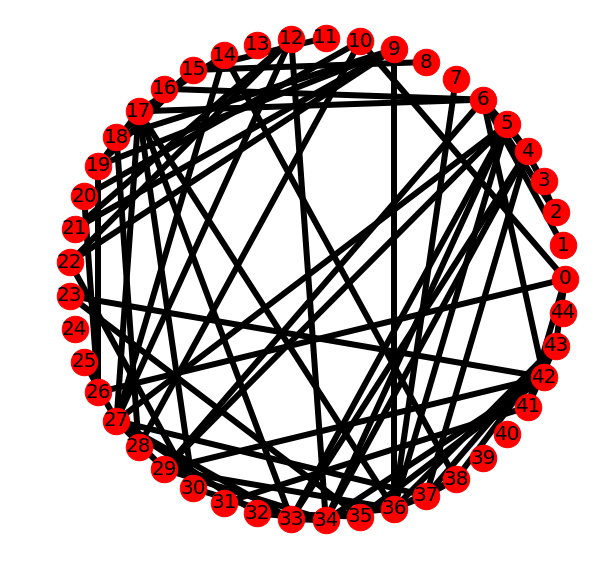

In [32]:
G = nx.from_scipy_sparse_matrix(similarity_graph)

plt.figure(figsize = (10,10))

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.1]
#esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.1]
enull = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] < 0.1]
    
pos = nx.circular_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=6)
#nx.draw_networkx_edges(G, pos, edgelist=esmall,
#                       width=6, alpha=0.5, edge_color='b', style='dashed')

# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')


plt.axis('off')
plt.show()

## Apply pagerank (i.e textrank) algorithm

Textrank is obtained through application of the network method ```pagerank()```. According its documentation:

"The eigenvector calculation is done by the power iteration method and has no guarantee of convergence. The iteration will stop after max_iter iterations or an error tolerance of number_of_nodes(G)*tol has been reached.

The PageRank algorithm was designed for directed graphs but this algorithm does not check if the input graph is directed and will execute on undirected graphs by converting each edge in the directed graph to two edges."

In [33]:
sorted_sentences = np.argsort(list(nx.pagerank(G,weight='weight').values()))[::-1]
sorted_sentences

array([36,  6, 17, 38, 33,  9, 42, 34,  4, 37,  5, 12, 27, 29, 41, 19, 43,
       21, 14,  0, 10, 32, 44, 22, 18,  8, 23, 39, 35,  3, 30, 16, 26, 15,
        7, 20,  2, 28, 40, 24, 13, 25, 11, 31,  1])

In [51]:
def get_summary_sentences(matrix,sorted_sentences):
    # sum the rows of the matrix Bag of words, flatten it and reshape, extracting the sublist to have the count of words
    count_words = np.array(np.sum(matrix,axis=1).flatten().reshape(-1,))[0]
    cumcount_words = np.cumsum(count_words) # cumulative sum to count the words along the summary to be written
    
    # find the num of sentences to keep in the summary (shourld be between 85 and 115 words (100+-15%))
    # count the number of words until the one before it reaches 100 words or the first one to supass 100
    # lower boundary (before 100)
    if len(cumcount_words[cumcount_words<=100])>1:
        lb = cumcount_words[cumcount_words<=100][-1]
    else:
        lb = cumcount_words[cumcount_words<=100]
    # upper boundary (after 100)
    if len(cumcount_words[cumcount_words>100])>1:
        ub = cumcount_words[cumcount_words>100][0]
    else:
        ub = cumcount_words[cumcount_words>100]
    
    # use flags to know if the summary is smaller than 85 words (smaller_sumamry) or greater than 115 (bigger_summary)
    bigger_summary = False
    smaller_summary = False
    
    if (ub-100)< (100-lb): # the upper boundary is nearer to 100
        numsent2keep = len(cumcount_words[cumcount_words>100])
        numwords_summary = ub # number of words in summary
        if ub > 115: # check if it surpasses 115 and raise the flag
            bigger_summary = True

    else: # the lower boundary is nearer to 100
        numsent2keep = len(cumcount_words[cumcount_words<=100])
        numwords_summary = lb # number of words in summary
        if lb < 85: # check if it is smaller than 85 and raise the flag
            smaller_summary = True

    # stroe the flags and the word count in a dictionary for reference
    out_of_range_dict = {'numwords_summary':numwords_summary,'bigger_summary':bigger_summary,'smaller_summary':smaller_summary}
        

    # extract only the sentences to write the summary
    summary_sentences = sorted_sentences[:numsent2keep]
    summary_sentences
    # print(f'Sentences indices that will be in the summary = {summary_sentences}')
    return summary_sentences, out_of_range_dict

summary_sentences,out_of_range_dict = get_summary_sentences(matrix,sorted_sentences)

In [66]:
def create_summary(summary_sentences,sentences):
    summary = ''
    for index_ in summary_sentences:
        summary += sentences[index_]
        
    return summary

summary = create_summary(summary_sentences,sentences)

## Compilation of all the procedure above in one function

Implement a function summarize() which will get a raw text and create the summary.

In [53]:
out_of_range_all = {'numwords_summary':[],'bigger_summary':[],'smaller_summary':[]}
def summarize(text):
    sentences = split_sentences(text)
    matrix = bag_of_words(sentences)
    normalized_matrix = TfidfTransformer().fit_transform(matrix)
    similarity_graph = np.dot(normalized_matrix,normalized_matrix.T)
    G = nx.from_scipy_sparse_matrix(similarity_graph)
    sorted_sentences = np.argsort(list(nx.pagerank(G,weight='weight').values()))[::-1]
    summary_sentences,out_of_range_dict = get_summary_sentences(matrix,sorted_sentences)
    out_of_range_all['numwords_summary'].append(out_of_range_dict['numwords_summary'])
    out_of_range_all['bigger_summary'].append(out_of_range_dict['bigger_summary'])
    out_of_range_all['smaller_summary'].append(out_of_range_dict['smaller_summary'])
    summary = create_summary(summary_sentences,sentences)
    
    return summary

### Apply the summarization to all training dataset

In [76]:
df['my_summary'] = df['source'].apply(summarize)
df['my_summary'].replace('', np.nan, inplace=True)
df.dropna(inplace=True)
#df.mask(df.eq('None')).dropna()
df.head()

,source,summary,my_summary
0,Minghella war der Sohn italienisch-schottische...,"Anthony Minghella, CBE war ein britischer Film...","Auch als Produzent war er erfolgreich, darunte..."
1,Ende der 1940er Jahre wurde eine erste Auteur-...,Die Auteur-Theorie ist eine Filmtheorie und di...,"Das Konzept des Regisseurs als ""auteur"" seiner..."
2,"Al Pacino, geboren in Manhattan, ist der Sohn ...","Alfredo James ""Al"" Pacino ist ein US-amerikani...","Al Pacino, geboren in Manhattan, ist der Sohn ..."
3,Der Name der Alkalimetalle leitet sich von dem...,Als Alkalimetalle werden die chemischen Elemen...,Mit Sauerstoff reagieren die Metalle unter Bil...
4,Die Arbeit ist bereits seit dem Altertum Gegen...,Das deutsche Arbeitsrecht ist ein Rechtsgebiet...,Zu unterscheiden ist die Mitbestimmung der Arb...


In [77]:
# Description of out of range summaries
numtotal_summaries = len(df)
# Number of Bigger summaries
numbigger_summaries = sum(out_of_range_all['bigger_summary'])
# Number of Smaller summaries
numsmaller_summaries = sum(out_of_range_all['smaller_summary'])
'''
# number of words only from bigger summaries
numwords_bigger = out_of_range_all['numwords_summary'][out_of_range_all['bigger_summary']]
# number of words only from smaller summaries
numwords_smaller = out_of_range_all['numwords_summary'][out_of_range_all['smaller_summary']]

# Average size of bigger summary
avgwords_bigger = sum(numwords_bigger)/len(numwords_bigger)
avgwords_smaller = sum(numwords_smaller)/len(numwords_smaller)
'''

print('Out of Range Summaries')
print(f'Number of bigger summaries = {numbigger_summaries}')
print(f'Number of bigger summaries = {numsmaller_summaries}')


'''
print(f'Average number of words of bigger summaries = {avgwords_bigger}')
print(f'Average number of words of smaller summaries = {avgwords_smaller}')
'''

Out of Range Summaries
Number of bigger summaries = 3948
Number of bigger summaries = 4456


"\nprint(f'Average number of words of bigger summaries = {avgwords_bigger}')\nprint(f'Average number of words of smaller summaries = {avgwords_smaller}')\n"

## Evaluate goodness of the summarization process through Rouge-1 and Rouge-2

Evaluate the quality of the machine-generated summary using Rouge-1 and Rouge-2. In this regards, three metrics can be used, F, P and R, as mentioned by Lin (--). The following equations defines such metrics.

$$R=\frac{\sum_{i=1}^u LCS(r_i,C)}{m}$$

$$P=\frac{\sum_{i=1}^u LCS(r_i,C)}{n}$$

$$F=\frac{(1+\beta^2)RP}{R+\beta^2 P}$$

Where LCS refers to the longest common subsequence in both summaries, i.e  a  common  subsequence  with  maximum  length. $\beta$ is as the ratio between $P$ and $R$.

In this notebook, the application of rouge is done using the module rouge. Documentation is available in the following link:

https://github.com/pltrdy/rouge

As mentioned by Lin (--), the F metrics is the most robust one betwenn the three available (F, P and R). Therefore, this one was used to investigate the quality of the summaries obtained.

In [78]:
from rouge import Rouge 

rouge = Rouge()
scores = rouge.get_scores(df['summary'],df['my_summary'])

In [79]:
rouge1 = [scores[n]['rouge-1']['f'] for n in range(len(scores))]
rouge2 = [scores[n]['rouge-2']['f'] for n in range(len(scores))]

print(f'Average Rouge-1 (F-metrics) = {sum(rouge1)/len(rouge1)}')
print(f'Average Rouge-2 (F-metrics) = {sum(rouge2)/len(rouge2)}')

Average Rouge-1 (F-metrics) = 0.15974092102209886
Average Rouge-2 (F-metrics) = 0.03874410274506783


The average value of Rouge-1 and Rouge-2 for the machine-generated summaries are relatively low. This may be expected, since the algorithm of TextRank works basically by rearranging the sentences in a order according similarity, without any rewriting or rearrangement of the words.

Additionaly, only the average does not provide a realistic insight over the distribution of rouge-1 values for the entire dataset. With such purpose, the histograms below illustrates the distribution of the two metrics for the entire set. 

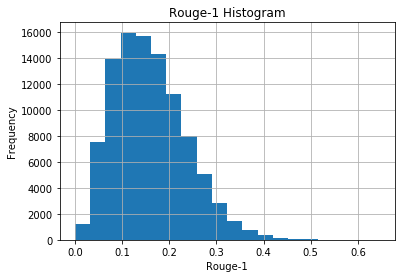

In [81]:

plt.hist(rouge1,bins=20);
plt.title('Rouge-1 Histogram')
plt.xlabel('Rouge-1')
plt.ylabel('Frequency')
plt.grid()



Text(0, 0.5, 'Frequency')

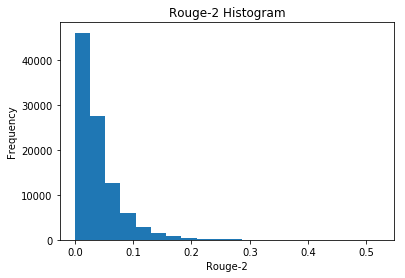

In [82]:
plt.hist(rouge2,bins=20);
plt.title('Rouge-2 Histogram')
plt.xlabel('Rouge-2')
plt.ylabel('Frequency')

### Apply the algorithm to the Test set

In the following code, the developed algorithm is applied in the Test set. However, **no metrics** is here investigated since there is no provided summary to serve as a reference in regards the quality of the machine-generated one.

In [83]:
out_of_range_all = {'numwords_summary':[],'bigger_summary':[],'smaller_summary':[]}
print('Importing data...')
df2 = import_text("Summarization_test.csv")
print('Data imported')
df2 = preprocess_text(df2)
print('Summarizing...')
df2['my summary'] = df2['source'].apply(summarize)
df2.head()

Importing data...
Data imported
Summarizing...


,source,my summary
0,Das Kelvin wurde durch die Generalkonferenz fu...,In der zukünftigen Definition wird das Kelvin...
1,Campbell wurde als Tochter eines schottischen ...,2011 war sie zum vierten mal in der Rolle der ...
2,Roland Emmerich wurde in Stuttgart-Obertürkhe...,"Im Sommer 2014 drehte Emmerich das Drama ""Ston..."
3,Das Stasi-Unterlagen-Gesetz ist die gesetzlich...,Dieses Gesetz ist die Basis für jegliche Tät...
4,"Der Enzkreis hat Anteil am Nordschwarzwald, Kr...",Der Enzkreis organisiert zusammen mit der Stad...


In [85]:
# Description of out of range summaries
numtotal_summaries = len(df)
# Number of Bigger summaries
numbigger_summaries = sum(out_of_range_all['bigger_summary'])
# Number of Smaller summaries
numsmaller_summaries = sum(out_of_range_all['smaller_summary'])

'''
# number of words only from bigger summaries
numwords_bigger = out_of_range_all['numwords_summary'][out_of_range_all['bigger_summary']]
# number of words only from smaller summaries
numwords_smaller = out_of_range_all['numwords_summary'][out_of_range_all['smaller_summary']]

# Average size of bigger summary
avgwords_bigger = sum(numwords_bigger)/len(numwords_bigger)
avgwords_smaller = sum(numwords_smaller)/len(numwords_smaller)
'''
print('Out of Range Summaries')
print(f'Number of bigger summaries = {numbigger_summaries}')
print(f'Number of bigger summaries = {numsmaller_summaries}')
'''
print(f'Average number of words of bigger summaries = {avgwords_bigger}')
print(f'Average number of words of smaller summaries = {avgwords_smaller}')
'''

Out of Range Summaries
Number of bigger summaries = 33
Number of bigger summaries = 38


"\nprint(f'Average number of words of bigger summaries = {avgwords_bigger}')\nprint(f'Average number of words of smaller summaries = {avgwords_smaller}')\n"